# Sentiment analysis on Reviews given by viewers on IMDB

# The Dataset and The Problem to Solve

In this notebbok, we’ll use an IMDB dataset of 50k movie reviews available on Kaggle. The dataset contains 2 columns (review and sentiment) that will help us identify whether a review is positive or negative.
Problem formulation: Our goal is to find which machine learning model is best suited to predict sentiment (output) given a movie review (input).

# 1. Importing necessary libraries



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier



# 2. Preparing the data

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [3]:
df.shape

(50000, 2)

In [4]:
df.head

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

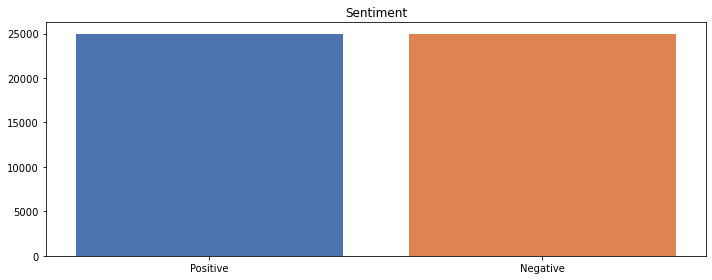

In [7]:
df_positive = df[df['sentiment']=='positive']
df_negative = df[df['sentiment']=='negative']

df_review_imb = pd.concat([df_positive,df_negative ])
colors = sns.color_palette('deep')
plt.figure(figsize=(10,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:5])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

In [8]:
print('Positive review: ', df_positive)
print('\n')
print('Negative review: ', df_negative)
print('\n')

Positive review:                                                    review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
4      Petter Mattei's "Love in the Time of Money" is...  positive
5      Probably my all-time favorite movie, a story o...  positive
...                                                  ...       ...
49983  I loved it, having been a fan of the original ...  positive
49985  Imaginary Heroes is clearly the best film of t...  positive
49989  I got this one a few weeks ago and love it! It...  positive
49992  John Garfield plays a Marine who is blinded by...  positive
49995  I thought this movie did a down right good job...  positive

[25000 rows x 2 columns]


Negative review:                                                    review sentiment
3      Basically there's a family where a little boy ...  negativ

# 3. Splitting data into train and test set

In [9]:
#split the dataset  
#train dataset
train_reviews=df.review[:40000]
train_sentiments=df.sentiment[:40000]
#test dataset
test_reviews=df.review[40000:]
test_sentiments=df.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


# 4. Data Cleaning

**Text normalization**

In [10]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

**Removing html strips and noise text**

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


**Removing special characters**

In [12]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

**Text stemming**

In [13]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

**Removing stopwords**

In [14]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'hasn', 'y', 'o', 'some', "isn't", 'by', 'for', 'on', 'needn', 'ain', 'couldn', 'at', 'through', 'how', 'wasn', "doesn't", 'hadn', 'during', "aren't", 'ma', 'theirs', 'shan', 'ours', 'myself', 'once', 'it', "wasn't", 'had', "couldn't", 'from', 'such', 'do', 'weren', 'until', 'below', 'few', 'didn', 'if', 'shouldn', 'our', 'him', 'with', 'you', 'any', 'won', 'having', "shouldn't", 'yourself', 'off', 'again', 'in', 'those', "you've", 'further', 'an', 'they', 'mightn', 'over', 'can', 'i', 'is', 'have', 'down', 'under', "mightn't", 'be', 'own', "that'll", 'doesn', 'not', 'm', 'did', 'are', 'of', 'should', 'she', 'what', 'isn', 'which', 'my', 'why', 't', 'both', "should've", 'himself', 'itself', 'here', 'so', 'does', 'yourselves', 'about', 'only', 'don', "needn't", 'as', "won't", "you're", 'too', 'your', 'ourselves', 'out', 'am', 'than', 're', "you'd", 'while', 'each', 'hers', 'same', 'the', 'when', 'most', "she's", 'or', 'its', 'we', 'just', "didn't", 'herself', "hasn't", 'll', 'he', 'abo

**Normalised Train Review**

In [15]:
norm_train_reviews=df.review[:40000]
norm_train_reviews[1000]

'thi movi aw cant even bother write review thi garbag say one bore film ive ever seenand act veri bad boy play main charact realli annoy got express hi face movi want slap basic 80 movi slow motion shot skateboard weird music utter shtappar ive got write least 10 line text submit thi comment ill use line say lead charact ha got one face want slapmeh give upthi movi suck'

**Normalised Test Review**

In [16]:
norm_test_reviews=df.review[40000:]
norm_test_reviews[48000]

'ten ten star exagger thi documentari provid viewer uniqu footag 2003 coup venezuela thi great film minimum knowledg requir want express compet opinion venezuela hugo chavezth dramat electrifi atmospher uniqu footag allow experi true histor moment youll feel like middl situat film help gain uniqu insight happen 2003 help hear side rare hear tv someth shouldnt miss'

<function matplotlib.pyplot.show(close=None, block=None)>

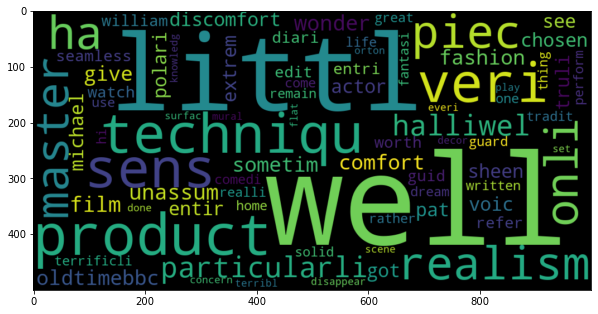

In [17]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

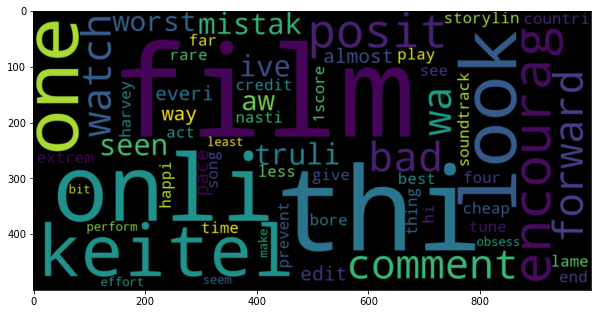

In [18]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

# 5. Text Representation (Bag of words)

Classifiers and learning algorithms expect numerical feature vectors rather than raw text documents. This is why we need to turn our movie review text into numerical vectors.

We’ll use bag of words (BOW) since we care about the frequency of the words in text reviews; however, the order of words is irrelevant. Two common ways to represent bag of words are CountVectorizer and Term Frequency, Inverse Document Frequency (TF-IDF)

1. **Bow-of-Words**; simply counts how many times each word appears in a document.

In [19]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


2. **TF-IDF**; multiples term frequency with inverse document frequency. This puts more weight on words that don't appear in many documents. 

In [20]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


**Labeling the sentiment text**

In [21]:
#labeling the sentiment data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['sentiment'])
print(sentiment_data.shape)

(50000, 1)


**Split the sentiment data**

In [22]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# 6. Model Training

# I. Logistic Regression

**a) For BOW**

In [23]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


**Model performance on test data**

In [24]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

[0 0 0 ... 0 0 0]


**Accuracy of the model**

In [25]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.5981


**Classification report**

In [26]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.56      0.98      0.71      4993
    Negative       0.91      0.22      0.35      5007

    accuracy                           0.60     10000
   macro avg       0.73      0.60      0.53     10000
weighted avg       0.73      0.60      0.53     10000



**Confusion matrix**

In [27]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)

[[1092 3915]
 [ 104 4889]]


 **b) For TFIDF**

In [28]:
#training the model
lr= LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_tfidf=lr.fit(cv_train_reviews,train_sentiments)
print(lr_tfidf)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


**Model performance on test data**

In [29]:
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 0]


**Accuracy of the model**

In [30]:
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.5044


**Classification report**

In [31]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.50      1.00      0.67      4993
    Negative       0.98      0.01      0.02      5007

    accuracy                           0.50     10000
   macro avg       0.74      0.51      0.34     10000
weighted avg       0.74      0.50      0.34     10000



**Confusion matrix**

In [32]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[  52 4955]
 [   1 4992]]


# II. Multinomial Naive Bayes 

**a) For BOW**

In [33]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [34]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

[0 0 0 ... 0 1 1]


In [35]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_bow_score : 0.7474


In [36]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.74      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [37]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)

[[3641 1366]
 [1160 3833]]


**b) For TFIDF**

In [38]:
#training the model
mnb=MultinomialNB()
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [39]:
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]


In [40]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_tfidf_score : 0.7509


In [41]:
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [42]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3729 1278]
 [1213 3780]]


# 7. Conclusion

We can summarize the findings as follows:

* TF-IDF did **marginally better** than Bag-of-Words; although the difference was less than 1% in F-1 score. 
* Logistic Regression **outperformed** Naive Bayes by at least 2% in F-1 score in both cases. 
* Logistic Regression may have performed better because of its ability to **regularize** on the large vocabulary.